In [1]:
#calculate position of 0 wind stress line - timeseries off of Denman

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import pickle

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42627 Dashboard: /proxy/39353/status,Cluster Workers: 8 Cores: 8 Memory: 200.00 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

In [4]:
#cc.querying.get_experiments(session)

In [5]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [6]:
expt='01deg_jra55v140_iaf'
variable='ht'
ht = cc.querying.getvar('01deg_jra55v140_iaf','ht',session,n=1).sel(yt_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
ht.load()
print(ht.shape)

variable='hu'
hu = cc.querying.getvar(expt,variable,session, n=-1)
hu.load()
print(hu.shape)

(584, 3600)
(2700, 3600)


In [7]:
expt='01deg_jra55v140_iaf'
variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,session, n=-1)
yt_ocean.load()
print(yt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,session, n=-1)
area_t.load()
print(area_t.shape)

variable='xu_ocean'
xu_ocean = cc.querying.getvar(expt,variable,session, n=-1)
xu_ocean.load()
print(xu_ocean.values)

variable='yu_ocean'
yu_ocean = cc.querying.getvar(expt,variable,session, n=-1)
yu_ocean.load()
print(yu_ocean.shape)

variable='area_u'
area_u = cc.querying.getvar(expt,variable,session, n=-1)
area_u.load()
print(area_u.shape)

variable='st_ocean'
st_ocean = cc.querying.getvar(expt,variable,session, n=-1)
st_ocean.load()
print(st_ocean.shape)

(3600,)
(2700,)
(2700, 3600)
[-279.9 -279.8 -279.7 ...   79.8   79.9   80. ]
(2700,)
(2700, 3600)
(75,)


In [8]:
def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

In [9]:
hu = change_lon_space(hu, 'u')

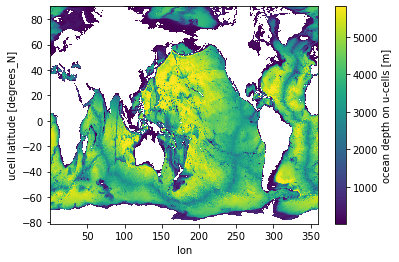

In [10]:
hu.plot.pcolormesh()

In [11]:
#txx=[]

tx1=xr.open_dataset('/g/data/v45/pas561/jnb/ensoant/data/taux_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)

tx2=xr.open_dataset('/g/data/v45/pas561/jnb/ensoant/data/taux_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)

#txx=np.asarray(txx)
#print(txx.shape)



In [12]:
tx1

<xarray.Dataset>
Dimensions:   (time: 61, xu_ocean: 3600, yu_ocean: 583)
Coordinates:
  * time      (time) int64 0 365 731 1096 1461 ... 20454 20819 21185 21550 21915
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -55.15 -55.1 -55.04
Data variables:
    tau_x     (time, yu_ocean, xu_ocean) float32 ...

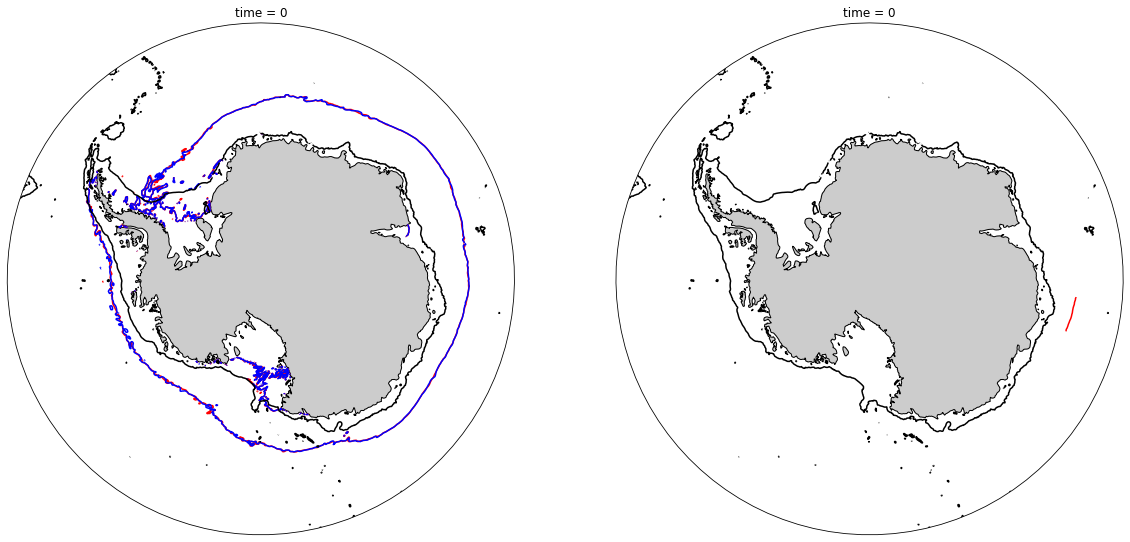

In [14]:
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# isel(st_ocean=(37))

#p1 = ltm_temp1.ltm_temp1.sel(st_ocean=(400),method='nearest').plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=278, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = tx1.tau_x[0].plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='r',linewidth=1,
                       transform=ccrs.PlateCarree())
p2 = tx2.tau_x[0].plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='b',linewidth=1,
                       transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
#                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

a=(tx1.tau_x + tx2.tau_x)/2
p1a = a[0].sel(yu_ocean=slice(-90,-62)).sel(xu_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='g',linewidth=1,
                       transform=ccrs.PlateCarree())


ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# isel(st_ocean=(37))

p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
#                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

a=(tx1.tau_x + tx2.tau_x)/2
p1c = a[0].sel(yu_ocean=slice(-90,-60)).sel(xu_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='r',linewidth=1,
                       transform=ccrs.PlateCarree())
#ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
#cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical', extend='both')
#cb.ax.set_xlabel('°C');




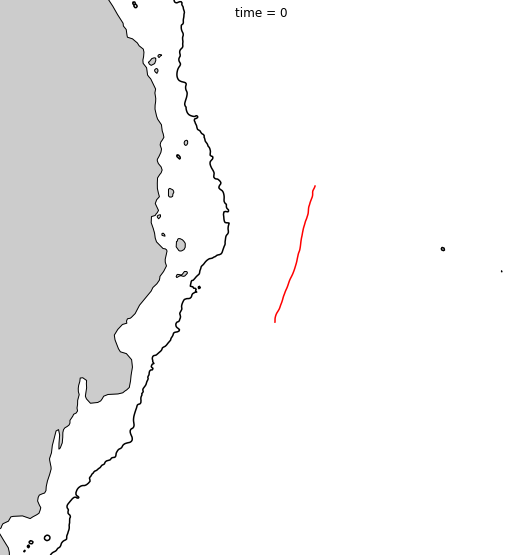

In [15]:
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

plt.title('0 Tau_X')

#ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
#cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical', extend='both')
#cb.ax.set_xlabel('°C');

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-275, -245, -70, -55], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# isel(st_ocean=(37))

p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
#                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
p1a = tx1.tau_x[0].sel(yu_ocean=slice(-90,-62)).sel(xu_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='g',linewidth=1,
                       transform=ccrs.PlateCarree())
#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
p1b = tx2.tau_x[0].sel(yu_ocean=slice(-90,-62)).sel(xu_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='b',linewidth=1,
                       transform=ccrs.PlateCarree())

a=(tx1.tau_x + tx2.tau_x)/2
p1c = a[0].sel(yu_ocean=slice(-90,-60)).sel(xu_ocean=slice(-265,-255)).plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='r',linewidth=1,
                       transform=ccrs.PlateCarree())



01deg_jra55v140_iaf_cycle2
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(12, 583, 300)
(1, 583, 300)
../data/01deg_jra55v140_iaf_cycle2_Tx0lines_275to245.pkl
01deg_jra55v140_iaf_cycle3
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(60, 583, 300)
(5, 583, 300)
(12, 583, 300)
(1, 583, 300)
../data/01deg_jra55v140_iaf_cycle3_Tx0lines_275to245.pkl


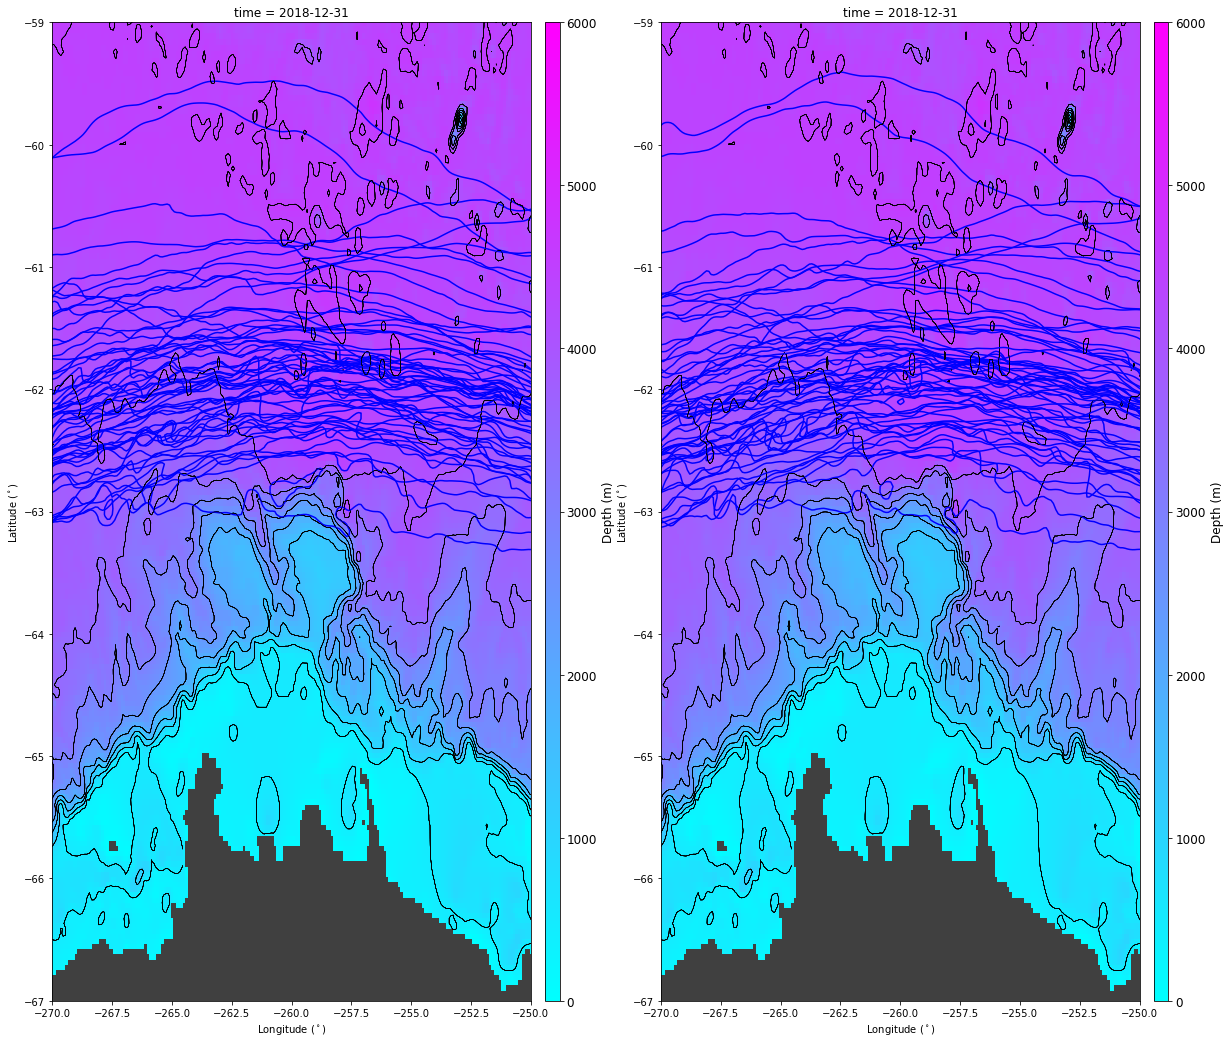

In [13]:
start = '1958-01-01 00:00:00'
end = '2019-01-01 00:00:00'

expts=['01deg_jra55v140_iaf_cycle2','01deg_jra55v140_iaf_cycle3']

clev = np.arange(0,6000,10)
clev2 = np.arange(0,6000,500)
fontsize=12

fig = plt.figure(figsize=(20, 18))

cnt=0
for i in expts:
    cnt=cnt+1
    print(i)
    ds = cc.querying.getvar(i, variable='tau_x', 
                       session=session, frequency='1 monthly',
                       start_time=start, 
                       end_time=end)
    
    all = []
    #cycle thru time chunks 
    for ii, ds_dec in ds.resample({'time':'5YS'}):
        #print(i,ds_dec)
        t=ds_dec.sel(time=slice(start,end)).sel(yu_ocean=slice(-90,-55)).sel(xu_ocean=slice(-275,-245))
        print(t.shape)
        
        #t = t.resample({'time':'QS-Mar'}).mean('time')
        t = t.resample({'time':'Y'}).mean('time')
        print(t.shape)
        
        ax = plt.subplot(1, 2, cnt)
        plt.gca().patch.set_color('.25')
        p2=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
        plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
        
        for iii in t:
            #print(iii)
            p1 = iii.plot.contour(ax=ax,
                       x='xu_ocean', y='yu_ocean', levels=[0], colors='b',linewidth=1)

            pth1 = p1.collections[0].get_paths()
            pth1.sort(key=len,reverse=True)
            v1 = pth1[0].vertices
            x1 = v1[:,0]
            y1 = v1[:,1]

            all.append(v1)

    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.ylim([-67,-59])
    plt.xlim([-270,-250])
    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.2)
    cbar = plt.colorbar(p2, cax=cax,orientation = 'vertical',extend = 'neither')
    cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
        
    fo='../data/'+str(i)+'_Tx0lines_275to245.pkl'
    print(fo)
    
    with open(fo, 'wb') as f:
        pickle.dump(all, f)

In [14]:
with open('../data/01deg_jra55v140_iaf_cycle2_Tx0lines_275to245.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))

61


61
61


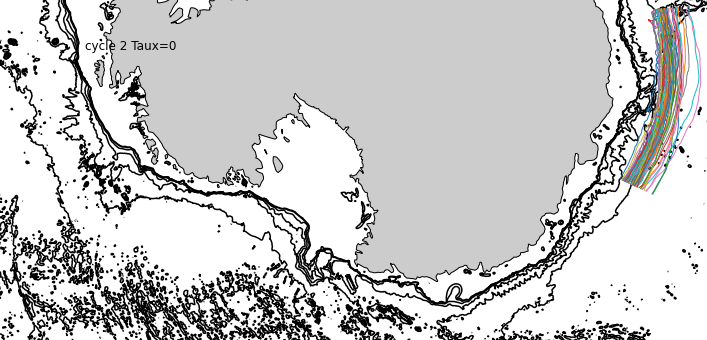

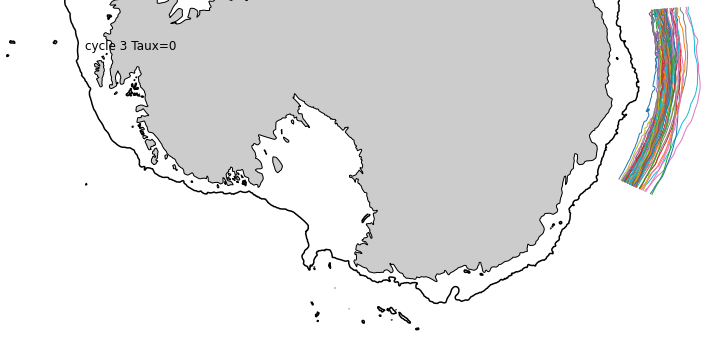

In [15]:
with open('../data/01deg_jra55v140_iaf_cycle2_Tx0lines_275to245.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))
#print(all[0][:,1])

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-160, -95, -75, -65], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=10, colors='k',linewidth=0.5,
                       transform=ccrs.PlateCarree())
yr=1957
for a in all:
    yr+=1
    all[0][:,1]
    ax.plot(a[:,0],a[:,1],'-',linewidth=1,label=yr,transform=ccrs.PlateCarree())

#ax.legend()
plt.title('cycle 2 Taux=0')
plt.tight_layout()

with open('../data/01deg_jra55v140_iaf_cycle3_Tx0lines_275to245.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))
#print(all[0][:,1])

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-160, -95, -75, -65], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p3 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())

for a in all:
    all[0][:,1]
    ax.plot(a[:,0],a[:,1],'-',linewidth=1,transform=ccrs.PlateCarree())


plt.title('cycle 3 Taux=0')

plt.tight_layout()

In [16]:
aa=np.full((61,2),np.nan)

with open('../data/01deg_jra55v140_iaf_cycle2_Tx0lines_275to245.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))

cnt=-1
for a in all:
    cnt+=1
    aa[cnt,0]=np.mean(a[:,1])
    #print(np.mean(a[:,1]))

with open('../data/01deg_jra55v140_iaf_cycle3_Tx0lines_275to245.pkl', 'rb') as file:    
    # Call load method to deserialze
    all = pickle.load(file)
  
print(len(all))

cnt=-1
for a in all:
    cnt+=1
    aa[cnt,1]=np.mean(a[:,1])
    #print(np.mean(a[:,1]))

print(aa.shape)

61
61
(61, 2)


In [17]:
np.save('../data/01iafTx0lines_275to245',aa)

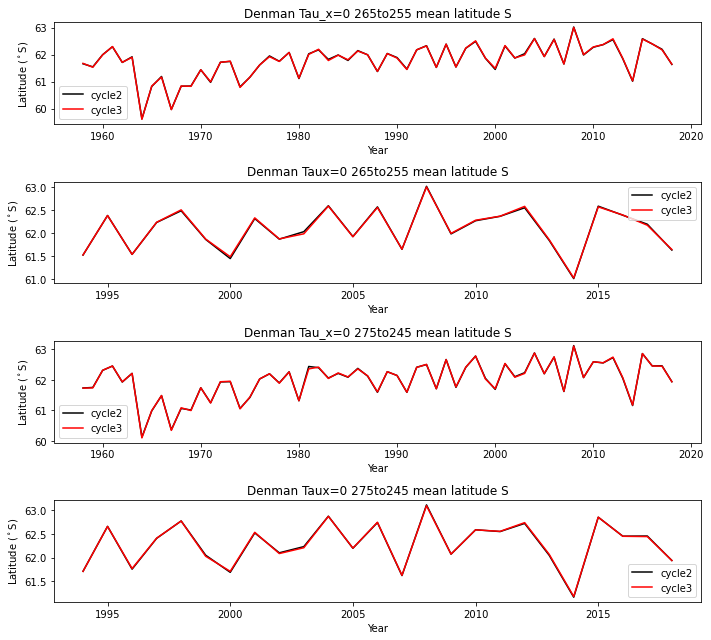

In [19]:
fig = plt.figure(figsize=(10, 9))

aa=np.load('../data/01iafTx0lines_265to255.npy')
yrs=np.arange(1958,2019)

ax1=plt.subplot(411)
#aa=np.nans(61,1)
ax1.plot(yrs[:],-aa[:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[:],-aa[:,1],linestyle='-',color='r',label='cycle3',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman Tau_x=0 265to255 mean latitude S')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)
plt.xlabel('Year')
plt.ylabel('Latitude ($^\circ$S)')

myr=36
ax1=plt.subplot(412)
#aa=np.nans(61,1)
ax1.plot(yrs[myr:],-aa[myr:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[myr:],-aa[myr:,1],linestyle='-',color='r',label='cycle3',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman Taux=0 265to255 mean latitude S')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)
plt.xlabel('Year')
plt.ylabel('Latitude ($^\circ$S)')


aa=np.load('../data/01iafTx0lines_275to245.npy')
yrs=np.arange(1958,2019)

ax1=plt.subplot(413)
#aa=np.nans(61,1)
ax1.plot(yrs[:],-aa[:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[:],-aa[:,1],linestyle='-',color='r',label='cycle3',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman Tau_x=0 275to245 mean latitude S')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)
plt.xlabel('Year')
plt.ylabel('Latitude ($^\circ$S)')

myr=36
ax1=plt.subplot(414)
#aa=np.nans(61,1)
ax1.plot(yrs[myr:],-aa[myr:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[myr:],-aa[myr:,1],linestyle='-',color='r',label='cycle3',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman Taux=0 275to245 mean latitude S')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)
plt.xlabel('Year')
plt.ylabel('Latitude ($^\circ$S)')

plt.tight_layout()